# Validation of simulation

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\bra}[1]{\langle#1|}$
$\newcommand{\ketbra}[2]{| #1 \rangle\langle #2 |}$

In [1]:
import logging
import numpy as np
import qutip as qtp
import matplotlib.pyplot as plt
from rqutils.math import matrix_exp
import rqutils.paulis as paulis
import qudit_sim
import qudit_sim.visualization

## Single qubit resonant drive

In [2]:
hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=100., amplitude=0.1)

In [3]:
qudit_sim.visualization.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

In [4]:
qudit_sim.visualization.print_hamiltonian(hgen.build(rwa=False))

<IPython.core.display.Latex object>

In [5]:
e_ops = [qtp.sigmaz()]
# Run for a π rotation in RWA
rwa_amp = hgen.build(rwa=True)[0].full()[0, 1].real
tlist = hgen.make_tlist(8, duration=(np.pi / rwa_amp), rwa=False)

In [6]:
result = qudit_sim.pulse_sim(hgen, psi0=qtp.basis(2, 0), tlist=tlist, e_ops=e_ops, log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 2668 time points from 0.000e+00 to 1.047e+01
INFO:qudit_sim.pulse_sim:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 5.201001 seconds.


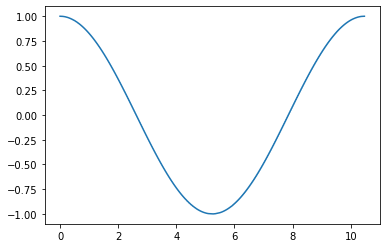

In [7]:
plt.plot(tlist, result.expect[0])

## Single qubit off-resonant drive

In [8]:
hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=101., amplitude=0.1)

In [9]:
qudit_sim.visualization.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

In the drive frame,

In [10]:
hgen.set_global_frame('drive')
qudit_sim.visualization.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

If we set psi0 to an eigenvector of this Hstatic, the state will approximately only acquire phases ($\langle X \rangle$, $\langle Y \rangle$, $\langle Z \rangle$ will stay constant):

In [11]:
Hstat = hgen.build(rwa=True)[0].full()
w, v = np.linalg.eigh(Hstat)
psi0 = qtp.Qobj(inpt=v[:, 0])

In [12]:
e_ops = [qtp.sigmax(), qtp.sigmay(), qtp.sigmaz()]
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=(8, 100), e_ops=e_ops, log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 801 time points from 0.000e+00 to 6.221e+00
INFO:qudit_sim.pulse_sim:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.798683 seconds.


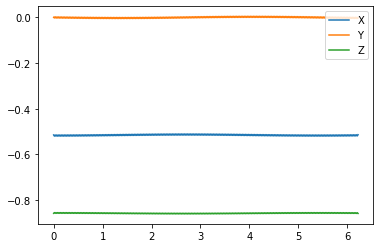

In [13]:
plt.plot(result.times, result.expect[0], label='X')
plt.plot(result.times, result.expect[1], label='Y')
plt.plot(result.times, result.expect[2], label='Z')
plt.legend();

These expectation values correspond to e.g.

$$
\bra{\psi(t)} U_d^{\dagger}(t) X U_d(t) \ket{\psi(t)} = \mathrm{tr} \left[ U_d(t) \rho_{\psi}(t) U_d^{\dagger}(t) X \right].
$$

Because $U_d(t) \rho_{\psi}(t) U_d^{\dagger}(t)$ is a $2 \times 2$ Hermitian matrix, it is completely determined by the three expectation values $\langle X \rangle$, $\langle Y \rangle$, and $\langle Z \rangle$.

In [14]:
components = np.stack((np.zeros_like(result.expect[0]), result.expect[0], result.expect[1], result.expect[2]))
# Compose 800 2x2 matrices from Pauli components
ud_rho_uddag = paulis.compose(components.T, dim=2)

The qudit-frame expectation values of X, Y, Z can be obtained from these results by

$$
\bra{\psi(t)} U_q^{\dagger}(t) X U_q(t) \ket{\psi(t)} = \mathrm{tr}\left[ U_q(t) U_d^{\dagger}(t) \left( U_d(t) \rho_{\psi}(t) U_d^{\dagger}(t) \right) U_d(t) U_q^{\dagger}(t) X \right]
$$

The unitary to move from the drive frame to the qudit frame is

$$
V_{qd}(t) = U_q(t) U_d^{\dagger}(t) = \exp \left(-i \frac{\omega_q - \omega_d}{2} \sigma_z t \right)
$$

In [15]:
tlist = result.times
e, o = hgen.frame_change_operator(from_frame='drive', to_frame='qudit')
vqd_diag = np.exp(1.j * (e[None, :] * tlist[:, None] + o))
uq_rho_uqdag = vqd_diag[..., None] * ud_rho_uddag * vqd_diag[:, None, :].conjugate()
qudit_frame_exp = paulis.components(uq_rho_uqdag, dim=2).real

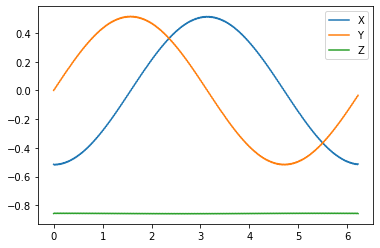

In [16]:
plt.plot(tlist, qudit_frame_exp[:, 1], label='X')
plt.plot(tlist, qudit_frame_exp[:, 2], label='Y')
plt.plot(tlist, qudit_frame_exp[:, 3], label='Z')
plt.legend();

Simulation result in the qudit frame:

In [17]:
hgen.set_global_frame('qudit')
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=tlist, e_ops=e_ops, log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 801 time points from 0.000e+00 to 6.221e+00
INFO:qudit_sim.pulse_sim:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.765183 seconds.


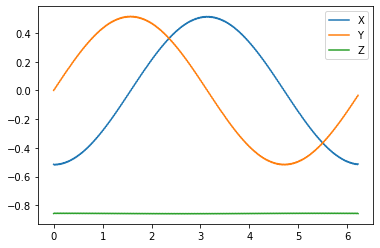

In [18]:
plt.plot(result.times, result.expect[0], label='X')
plt.plot(result.times, result.expect[1], label='Y')
plt.plot(result.times, result.expect[2], label='Z')
plt.legend();

## Single qutrit off-resonance

In [19]:
hgen = qudit_sim.HamiltonianBuilder(3)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=101., amplitude=0.1)

In [20]:
hamiltonian = hgen.build(rwa=True)
qudit_sim.visualization.print_hamiltonian(hamiltonian)

<IPython.core.display.Latex object>

In the drive frame,

In [21]:
hgen.set_global_frame('drive')
qudit_sim.visualization.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

Set psi0 to an eigenvector of this Hstatic:

In [22]:
Hstat = hgen.build(rwa=True)[0].full()
w, v = np.linalg.eigh(Hstat)
psi0 = qtp.Qobj(inpt=v[:, 0])

In [23]:
e_ops = [qtp.Qobj(inpt=l) for l in paulis.paulis(3)[1:]]
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=(8, 100), e_ops=e_ops, log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 801 time points from 0.000e+00 to 6.221e+00
INFO:qudit_sim.pulse_sim:Hamiltonian with 3 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.828925 seconds.


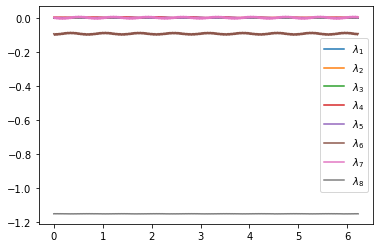

In [24]:
labels = paulis.labels(3)
for exp, label in zip(result.expect, labels[1:]):
    plt.plot(result.times, exp, label=f'${label}$')
plt.legend();

In [25]:
components = np.stack([np.zeros_like(result.expect[0])] + result.expect)
# Compose 200 3x3 matrices from Pauli components
ud_rho_uddag = paulis.compose(components.T, dim=3)

The unitary to move from the drive frame to the qudit frame is

$$
U_q(t) U_d^{\dagger}(t) = e^{i(\omega_q - \omega_d)t} \ketbra{1}{1} + e^{i[2(\omega_q - \omega_d) + \Delta]t} \ketbra{2}{2}
$$

In [26]:
tlist = result.times
e, o = hgen.frame_change_operator(from_frame='drive', to_frame='qudit')
vqd_diag = np.exp(1.j * (e[None, :] * tlist[:, None] + o))
uq_rho_uqdag = vqd_diag[..., None] * ud_rho_uddag * vqd_diag[:, None, :].conjugate()
qudit_frame_exp = paulis.components(uq_rho_uqdag, dim=3).real

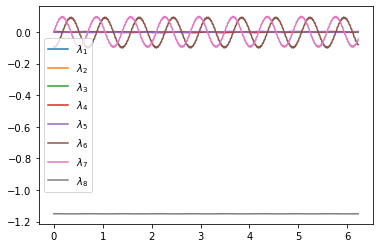

In [27]:
for ilabel, label in enumerate(labels):
    if ilabel == 0:
        continue
    plt.plot(tlist, qudit_frame_exp[:, ilabel], label=f'${label}$')

plt.legend();

Simulation result in the qudit frame:

In [28]:
hgen.set_global_frame('qudit')
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=tlist, e_ops=e_ops, log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 801 time points from 0.000e+00 to 6.221e+00
INFO:qudit_sim.pulse_sim:Hamiltonian with 3 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.656516 seconds.


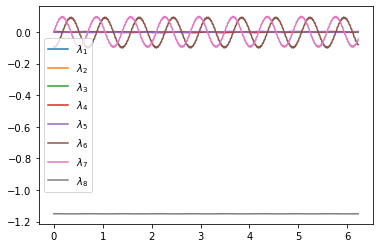

In [29]:
for exp, label in zip(result.expect, labels[1:]):
    plt.plot(result.times, exp, label=f'${label}$')
plt.legend();

## Two qubit cross resonance, no crosstalk

In [30]:
hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110., anharmonicity=-7., drive_amplitude=7., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 0.03)
hgen.add_drive('q0', frequency=hgen.frame('q1').frequency[0], amplitude=0.5+0.5j)

In [31]:
psi0_0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # |00>
psi0_1 = qtp.tensor(qtp.basis(2, 1), qtp.basis(2, 0)) # |10>
e_ops = [qtp.tensor(qtp.qeye(2), qtp.sigmay()), qtp.tensor(qtp.qeye(2), qtp.sigmaz())] # IY, IZ
result_0 = qudit_sim.pulse_sim(hgen, psi0=psi0_0, tlist=(8, 20), e_ops=e_ops, log_level=logging.INFO)
result_1 = qudit_sim.pulse_sim(hgen, psi0=psi0_1, tlist=(8, 20), e_ops=e_ops, log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 161 time points from 0.000e+00 to 1.142e+00
INFO:qudit_sim.pulse_sim:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.690367 seconds.
INFO:qudit_sim.pulse_sim:Using 161 time points from 0.000e+00 to 1.142e+00
INFO:qudit_sim.pulse_sim:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.669101 seconds.


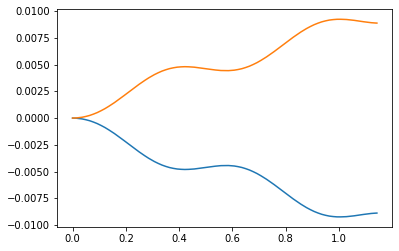

In [32]:
# Cross resonance drive induces a ZX term -> <IY> moves from 0 to opposite directions
plt.plot(result_0.times, result_0.expect[0])
plt.plot(result_1.times, result_1.expect[0]);

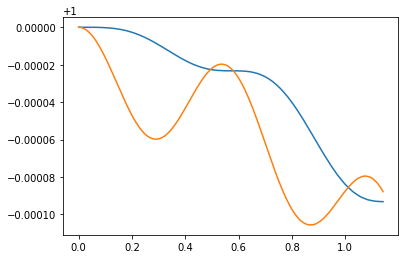

In [33]:
# <IZ> moves from 1 in the same direction
plt.plot(result_0.times, result_0.expect[1])
plt.plot(result_1.times, result_1.expect[1]);

## Two qutrit no drive, frame dependence

When couplings are present, the static Hamiltonian is no longer diagonal, causing a phase drift in the qudit frame. Here we use an unrealistically large coupling to demonstrate the effect by starting with a $\lambda_1$ eigenstate and tracking $\langle \lambda_i I \rangle$.

In [34]:
hgen = qudit_sim.HamiltonianBuilder(3)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110., anharmonicity=-7., drive_amplitude=7., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 3.)

In [35]:
psi0 = qtp.tensor(qtp.Qobj(inpt=np.array([np.sqrt(0.5)] * 2 + [0.])), qtp.basis(3, 0)) # |+0>
e_ops = [qtp.tensor(qtp.Qobj(inpt=p), qtp.qeye(3)) for p in paulis.paulis(3)[1:]]

Qudit frame evolution

In [36]:
hgen.set_global_frame('qudit')
qudit_sim.visualization.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

INFO:qudit_sim.pulse_sim:Using 161 time points from 0.000e+00 to 6.981e+00


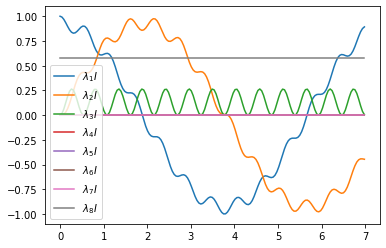

In [37]:
tlist = hgen.make_tlist(8, 20)
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=tlist, e_ops=e_ops, log_level=logging.INFO)

for exp, label in zip(result.expect, paulis.labels(3)[1:]):
    plt.plot(tlist, exp, label=f'${label}I$')

plt.legend();

Dressed frame evolution

In [38]:
hgen.set_global_frame('dressed')
qudit_sim.visualization.print_hamiltonian(hgen.build())

<IPython.core.display.Latex object>

INFO:qudit_sim.pulse_sim:Using 161 time points from 0.000e+00 to 6.981e+00


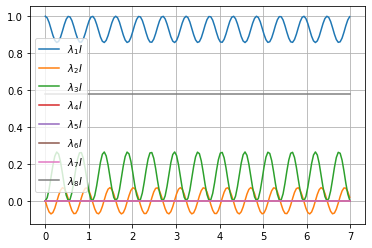

In [39]:
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=tlist, e_ops=e_ops, log_level=logging.INFO)

for exp, label in zip(result.expect, paulis.labels(3)[1:]):
    plt.plot(tlist, exp, label=f'${label}I$')

plt.grid()
plt.legend();